## Problem Statement

This notebook is a beginner's tutorial on how to classify handwritten digits using a custom dataset to train a neural network model. MNIST dataset is a popular image dataset that can be easily accessed using Pytorch or Tensorflow and has given state-of-the-art results in classifying English handwritten digits. But the dataset doesn't consist of images of digits for resource-contrained languages like Bengali. 

Hence, in this tutorial I introduce a new [Bengali dataset](https://www.kaggle.com/datasets/wchowdhu/bengali-digits) and use this dataset to implement a Bengali digit recognition system in PyTorch. The learned model takes as input an image of a Bengali digit and outputs the corresponding digit number from the 10 output classes. 

Please feel free to use the new Bengali dataset and this tutorial for experimentation :)

Let's get started!

## Import Necessary Libraries

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import trange
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

## Analyze the Dataset

The dataset is structured into 10 folders, each folder contains images of Bengali digits for the corresponding number:

    0 --> ০
    1 --> ১
    2 --> ২
    3 --> ৩
    4 --> ৪
    5 --> ৫
    6 --> ৬
    7 --> ৭
    8 --> ৮
    9 --> ৯

In [2]:
folders = glob.glob("../input/bengali-digits/bengali_digits/**")
len(folders)
folders

['../input/bengali-digits/bengali_digits/7',
 '../input/bengali-digits/bengali_digits/2',
 '../input/bengali-digits/bengali_digits/5',
 '../input/bengali-digits/bengali_digits/8',
 '../input/bengali-digits/bengali_digits/0',
 '../input/bengali-digits/bengali_digits/3',
 '../input/bengali-digits/bengali_digits/1',
 '../input/bengali-digits/bengali_digits/4',
 '../input/bengali-digits/bengali_digits/9',
 '../input/bengali-digits/bengali_digits/6']

There are total of 15,620 images in the entire dataset as printed below

In [3]:
files = glob.glob("../input/bengali-digits/bengali_digits/**/*.jpg") 
print("Size of the dataset: {}".format(len(files)))

Size of the dataset: 15620


Let's now look at the class distribution whether dataset is balanced across the 10 classes

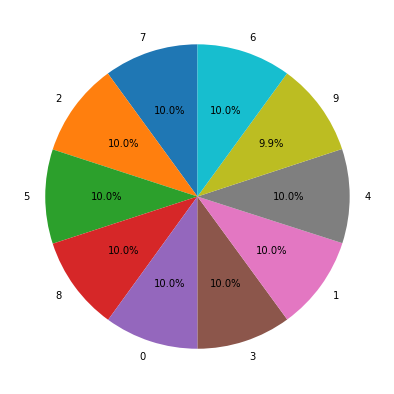

In [4]:
lens = []
for folder_path in folders:
  files = glob.glob(os.path.join(folder_path, '*.jpg'))
  lens.append(len(files))

numbers = ['7', '2', '5', '8', '0', '3', '1', '4', '9', '6'] 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(lens, labels=numbers, startangle=90, autopct='%1.1f%%')
plt.show()

We can see that the data is distributed fairly across the 10 output classes

## Read the Data

Read the data files from the source directory and assign corresponding target labels to the images. The image files and corresponding labels are then loaded into a pandas dataframe.

In [5]:
def read_data(data_dir='../input/bengali-digits/bengali_digits'):
    ''' Read data from source directory '''
    data = []
    labels = []
    for data_type in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        digit = int(data_type[-1])
        path = os.path.join(data_dir, data_type, '*.jpg')
        files = glob.glob(path)
        for f in files:
            data.append(f)
            labels.append(digit)
    assert len(data) == len(labels), "{}/{} Data size does not match labels size".format(len(data), len(labels))
    return data, labels


source_dir = '../input/bengali-digits/bengali_digits'
data, labels = read_data(source_dir)
assert len(data) == len(labels), "Number of image files do not match number of labels!"

df = pd.DataFrame(list(zip(data, labels)), columns =['file', 'label'])
df.head()

,file,label
0,../input/bengali-digits/bengali_digits/0/1_DHA...,0
1,../input/bengali-digits/bengali_digits/0/1_MAD...,0
2,../input/bengali-digits/bengali_digits/0/1_DHA...,0
3,../input/bengali-digits/bengali_digits/0/1_NOA...,0
4,../input/bengali-digits/bengali_digits/0/1_B.B...,0


## Split Data into Train-Validation-Test Subsets

The dataset is split into separate training, validation, and test subsets to train and evaluate the performance of the machine learning model. Stratification is applied to preserve the original distribution of the target classes.

In [6]:
def split_data(df, tsize=0.2):
    ''' Split the dataset into train-test subsets '''
    train, test = train_test_split(df, test_size=tsize, shuffle=True, stratify=df.label, random_state=123)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

train, test_subset = split_data(df, tsize=0.2)
train_subset, val_subset = split_data(train, tsize=0.1)

print("Total Training Examples: {}".format(len(train_subset)))
print("Total Validation Examples: {}".format(len(val_subset)))
print("Total Test Examples: {}".format(len(test_subset)))

Total Training Examples: 11246
Total Validation Examples: 1250
Total Test Examples: 3124


## Create a Custom Bengali Dataset Class 

PyTorch provides two classes -`torch.utils.data.DataLoader` and `torch.utils.data.Dataset` using which we can load our own data and train the machine learning model in batches. A custom Bengali Dataset class is firstly created by implementing the three methods: `__init__`, `__len__`, and `__getitem__`. 

In [7]:
class BengaliDigitDataset(Dataset):
    ''' A custom class to process the Bengali handwritten digit images '''
    
    def __init__(self, df, transform, width=28, height=28):
        ''' Initialize the parameters '''
        self.df = df
        self.transform = transform
        self.files = df['file']
        self.labels = df['label']
        self.width = width
        self.height = height

    def __len__(self):
        ''' Returns the total number of files in the dataset '''
        return len(self.files)

    def __getitem__(self, index):
        ''' Loads a sample from the dataset at the given index, which is identified by the image’s location on disk. 
        Returns the image tensors and corresponding labels after applying transformations. '''
        img = cv2.imread(self.files.iloc[index], cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(self.height, self.width), interpolation=cv2.INTER_AREA) #resize all the images to fixed heightxwidth
        img = self.transform(img)
        label = self.labels[index]
        return img,label

## Process the Data

An instance of the `BengaliDigitDataset` is then created to process the Bengali digit images. 

The following preprocessing steps are applied to the input images:
* Resize all the input images to a fixed shape 
* Transform raw images into tensors so that the algorithm can process them 
* Normalize the image tensors to have pixel values scaled down between -1 and 1 from 0 to 255 which helps with faster convergence

In [8]:
def prepocess_data(data_input, width, height):
    ''' Preprocess the input images '''
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    data_processed = BengaliDigitDataset(data_input, transform, width, height)
    return data_processed

width = 28
height = 28
train_pr = prepocess_data(train_subset, width, height)
val_pr = prepocess_data(val_subset, width, height)
test_pr = prepocess_data(test_subset, width, height)

Let's visualize a processed image

torch.Size([3, 28, 28])
9


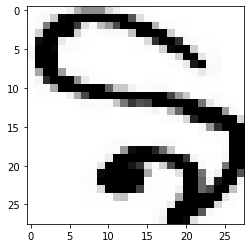

In [9]:
image, label = train_pr[0] #first image,label

print(image.shape) #torch.Size([channels, width, height])

image = image.numpy().transpose((1, 2, 0)) #transpose the image to shape torch.Size([width, height, channels])
plt.imshow(image)

print(label)

## Load the Data

The transformed image tensors are then loaded into the DataLoader which iterates through the dataset in minibatches and reshuffles the data at every epoch to reduce model overfitting.

In [10]:
# configuration settings
batch_size = 4000
seed = 123
random.seed(seed) # to get reproducible results
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) #when using gpu

train_dataloader = DataLoader(train_pr, batch_size, shuffle=True)
val_dataloader = DataLoader(val_pr, batch_size, shuffle=False)
test_dataloader = DataLoader(test_pr, batch_size, shuffle=False)

## Define the Model Architecture

A baseline neural network model is created by passing the input features into two hidden layers and adding dropout layer to avoid any overfitting.

In [11]:
class BengaliDigitClassifier(nn.Module):
    ''' Define the baseline model architecture '''
    def __init__(self, input_dim=2352, output_dim=10, hidden_1=32, hidden_2=32, dropout_frc=0.2):
        super(BengaliDigitClassifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_1) # Hidden layer-1 (input_dim -> hidden_1)
        self.hidden_layer = nn.Linear(hidden_1, hidden_2) # Hidden layer-2 (hidden_1 -> hidden_2)
        self.output_layer = nn.Linear(hidden_2, output_dim) # Output layer (hidden_2 -> output_dim)
        self.dropout_layer = nn.Dropout(dropout_frc) # Dropout prevents overfitting of data
    
    def forward(self, x):
        '''
        Perform a forward pass of the model on input features x
        :param x: A batch of input features of size (batch_size, color_channels, height, width)
        :return: logit outputs of shape [batch size, output dim]
        '''
        x = x.view(x.shape[0], -1) #reshape to [batch_size, color_channelsxheightxwidth]
        h1 = F.relu(self.input_layer(x)) # [batch size, hidden_1]
        h1 = self.dropout_layer(h1)
        h2 = F.relu(self.hidden_layer(h1)) # [batch size, hidden_2]
        h2 = self.dropout_layer(h2)
        y_pred = self.output_layer(h2) # [batch size, output_dim]
        return y_pred

## Build the Model

The model is created by defining the `Adam` optimizer, `cross entropy` loss function, and the hyperparameter settings

In [12]:
num_channels = 3
num_classes = 10
input_dim = int(num_channels * height * width)
output_dim = int(num_classes)
learning_rate = 0.003
n_epochs = 20

model = BengaliDigitClassifier(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #train on gpu if available
print("Using device {}.\n".format(device))
model = model.to(device)
criterion = criterion.to(device)
    
print(model)

Using device cuda.

BengaliDigitClassifier(
  (input_layer): Linear(in_features=2352, out_features=32, bias=True)
  (hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
)


Let's count the total number of trainable parameters

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print("The model has total {} trainable parameters".format(num_params))

The model has total 76682 trainable parameters


## Train the Model

To train the model, let's firstly define the train and evaluation functions

In [14]:
def eval_metric(predictions, labels):
    max_predictions = predictions.argmax(axis=1, keepdim=True) #[batch_size]
    avg_acc = round(accuracy_score(y_true=labels.to('cpu').tolist(), y_pred=max_predictions.detach().cpu().numpy()), 2)*100
    return avg_acc

def train_fn(model, train_loader, criterion, optimizer, device):
    '''
    Training function to run the model on training data
    model        - The PyTorch model that we wish to train.
    train_loader - The PyTorch DataLoader that should be used during training.
    criterion    - The loss function used for training.
    optimizer    - The optimizer to use during training.
    device       - Where the model and data should be loaded (gpu or cpu).
    '''
    model.train() #set the model on train mode
    total_loss, total_acc = 0, 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad() # clear gradients from last batch
        batch_y_pred = model(batch_x) # get predictions
        loss = criterion(batch_y_pred, batch_y) # compute the loss
        loss.backward() # compute the gradients
        optimizer.step() # update the parameters
        total_loss += loss.item() #aggregate the losses
        total_acc += eval_metric(batch_y_pred, batch_y)
    
    loss_per_epoch = total_loss/len(train_loader)
    acc_per_epoch = total_acc/len(train_loader)
    return loss_per_epoch, acc_per_epoch

def eval_fn(model, data_loader, criterion, device):
    '''
    Function to evaluate the model on validation and test data
    model        - The PyTorch model that we wish to train.
    data_loader - The PyTorch DataLoader that should be used during training.
    criterion    - The loss function used for training.
    optimizer    - The optimizer to use during training.
    device       - Where the model and data should be loaded (gpu or cpu).
    '''
    model.eval() # set the model on eval mode
    total_loss, total_acc = 0, 0
    
    with torch.no_grad(): # do not need to update the parameters
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_pred = model(batch_x) # get predictions
            loss = criterion(batch_y_pred, batch_y) # compute the loss
            total_loss += loss.item() #aggregate the losses
            total_acc += eval_metric(batch_y_pred, batch_y)
    
    loss_per_epoch = total_loss/len(data_loader)
    acc_per_epoch = total_acc/len(data_loader)
    return loss_per_epoch, acc_per_epoch

The model is then trained for a number of epochs by monitoring both the training as well as the validation loss and accuracy

In [15]:
train_losses, validation_losses = [], [] # Store train and validation losses for plotting
train_accuracies, validation_accuracies = [], []
best_val_loss = float('inf')

for epoch in trange(n_epochs, desc="Epoch"):
  train_loss_per_epoch, train_acc_per_epoch = train_fn(model, train_dataloader, criterion, optimizer, device)
  val_loss_per_epoch, val_acc_per_epoch = eval_fn(model, val_dataloader, criterion, device)

  train_losses.append(train_loss_per_epoch)
  validation_losses.append(val_loss_per_epoch)
  train_accuracies.append(train_acc_per_epoch)
  validation_accuracies.append(val_acc_per_epoch)

  if val_loss_per_epoch < best_val_loss:
    best_val_loss = val_loss_per_epoch
    torch.save(model.state_dict(), 'model.pt')

  print("Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(epoch, train_loss_per_epoch, train_acc_per_epoch))
  print("Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%\n".format(epoch, val_loss_per_epoch, val_acc_per_epoch))

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 2.1940, Train Accuracy: 19.67%
Epoch: 0, Validation Loss: 1.7774, Validation Accuracy: 40.00%

Epoch: 1, Train Loss: 1.7528, Train Accuracy: 38.67%
Epoch: 1, Validation Loss: 1.3560, Validation Accuracy: 62.00%

Epoch: 2, Train Loss: 1.4247, Train Accuracy: 52.67%
Epoch: 2, Validation Loss: 1.0249, Validation Accuracy: 74.00%

Epoch: 3, Train Loss: 1.1892, Train Accuracy: 61.33%
Epoch: 3, Validation Loss: 0.8236, Validation Accuracy: 77.00%

Epoch: 4, Train Loss: 1.0059, Train Accuracy: 67.33%
Epoch: 4, Validation Loss: 0.7103, Validation Accuracy: 79.00%

Epoch: 5, Train Loss: 0.9007, Train Accuracy: 70.00%
Epoch: 5, Validation Loss: 0.6485, Validation Accuracy: 79.00%

Epoch: 6, Train Loss: 0.8188, Train Accuracy: 73.00%
Epoch: 6, Validation Loss: 0.5982, Validation Accuracy: 80.00%

Epoch: 7, Train Loss: 0.7657, Train Accuracy: 74.67%
Epoch: 7, Validation Loss: 0.5590, Validation Accuracy: 83.00%

Epoch: 8, Train Loss: 0.7161, Train Accuracy: 76.67%
Epoch: 8, V

## Plot Training and Validation Losses over all Epochs

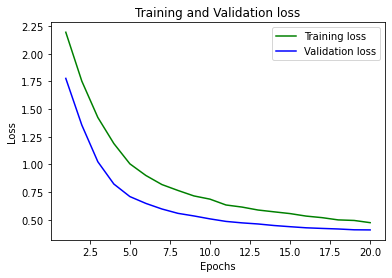

In [16]:
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plot Training and Validation Accuracies over all Epochs

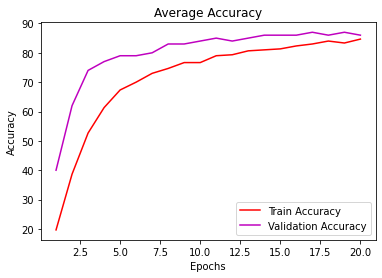

In [17]:
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'm', label='Validation Accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the Model on Test Data

The saved parameters of the best model is loaded and the performance of the model on the test subset is evaluated

In [18]:
model.load_state_dict(torch.load('model.pt'))
test_loss, test_accuracy = eval_fn(model, test_dataloader, criterion, device)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy))

Test Loss: 0.4253, Test Accuracy: 86.00%


## Look at the Confusion Matrix

Let's visualize the confusion matrix to evaluate the model performance for each class on the test data

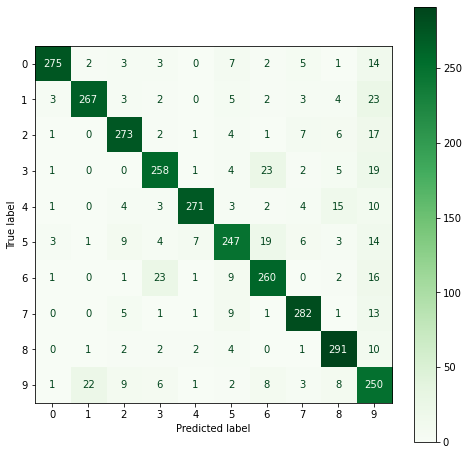

In [19]:
def predict(model, data_loader, device):
    model.eval()
    probs, labels = [], []   
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)    
            batch_y_pred = model(batch_x) # get predictions
            batch_y_prob = F.softmax(input=batch_y_pred, dim=-1) #[batch_size, output_classes]
            max_prob = batch_y_prob.argmax(axis=1, keepdim=True) #[batch_size, 1]
            max_prob = torch.squeeze(max_prob)
            probs.append(max_prob.detach().cpu().numpy())
            labels.append(batch_y.to('cpu').tolist())  
    return np.concatenate(probs, axis=0), np.concatenate(labels, axis=0)

def plot(predictions, labels):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, predictions)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Greens', ax=ax)
    

predictions, labels = predict(model, test_dataloader, device)
plot(predictions, labels)

From the confusion matrix, it can be seen that the model misclassifies digits which look similar. For example, the model misclassifies Bengali digits,

* 1 --> ১  as  9 --> ৯  in 23 digit images
* 4 --> ৪  as  8 --> ৮  in 15 digit images 
* 3 --> ৩  as  6 --> ৬  in 23 examples

The dataset is fairly small, containing 15,620 data images which is not enough data to estimate the many parameters in neural networks. Training the neural network on more data samples might help the model better differentiate between the similar digits and improve performance. Another option is to use a better model architecture like Convolutional Neural Networks. 

As a follow-up, I will write another tutorial on how to augment the current dataset by applying different transformations. 

That's it! This tutorial detailed how to train and evaluate a baseline neural network model on a custom dataset in PyTorch. 

<span style="color:blue">If you found this notebook helpful, please leave your feedback or any suggestions, and kindly upvote. Thanks!</span>